# 树叶分类kaggle竞赛
使用ResNet来对所给数据集进行训练。

In [1]:
!nvidia-smi

Mon Nov 11 19:41:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  |   00000000:01:00.0  On |                  N/A |
| 53%   64C    P8              9W /  120W |     265MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import random
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
from torch import nn
from IPython import display
from torch.utils import data
from torchvision import models
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## 1 读取数据

In [3]:
train_data_label = pd.read_csv("data/train.csv")
train_data_label.dtypes, train_data_label.shape

(image         object
 label         object
 num_label    float64
 dtype: object,
 (18353, 3))

In [4]:
print(train_data_label.iloc[0:8])

          image                     label  num_label
0  images/0.jpg          maclura_pomifera        NaN
1  images/1.jpg          maclura_pomifera        NaN
2  images/2.jpg          maclura_pomifera        NaN
3  images/3.jpg          maclura_pomifera        NaN
4  images/4.jpg          maclura_pomifera        NaN
5  images/5.jpg          maclura_pomifera        NaN
6  images/6.jpg               ulmus_rubra        NaN
7  images/7.jpg  broussonettia_papyrifera        NaN


## 2 对label列进行编码分类

In [5]:
num_label = pd.factorize(train_data_label['label'])[0]
train_data_label["num_label"] = num_label

In [6]:
train_data_label[0:20], train_data_label["image"][0], len(train_data_label["image"])

(            image                     label  num_label
 0    images/0.jpg          maclura_pomifera          0
 1    images/1.jpg          maclura_pomifera          0
 2    images/2.jpg          maclura_pomifera          0
 3    images/3.jpg          maclura_pomifera          0
 4    images/4.jpg          maclura_pomifera          0
 5    images/5.jpg          maclura_pomifera          0
 6    images/6.jpg               ulmus_rubra          1
 7    images/7.jpg  broussonettia_papyrifera          2
 8    images/8.jpg          maclura_pomifera          0
 9    images/9.jpg  broussonettia_papyrifera          2
 10  images/10.jpg          maclura_pomifera          0
 11  images/11.jpg         prunus_virginiana          3
 12  images/12.jpg          maclura_pomifera          0
 13  images/13.jpg         prunus_virginiana          3
 14  images/14.jpg  broussonettia_papyrifera          2
 15  images/15.jpg          maclura_pomifera          0
 16  images/16.jpg          maclura_pomifera    

## 3 加载自己数据集

### 3.1 生成随机数
- 因为这个电脑无法加载所有图片

### 3.1 自定义自己的Dataset类

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, data_label, image_name, transforms = None):
        super().__init__()
        self.img_path = data_path
        #self.label = torch.tensor(data_label)
        self.image_name = image_name
        self.transforms = transforms
        num = random.sample(range(0,len(train_data_label["image"])),8100)
        img = []
        label = []
        for i in num:
            img_path = self.img_path + '/' + image_name[i]
            img.append(Image.open(img_path))
            label.append(torch.tensor(data_label[i]))
        self.data = img
        self.label = label
        
    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        if self.transforms != None:
            data = self.transforms(data)
        
        return data, labels
    
    def __len__(self):
        return len(self.data)


In [8]:
img_path = "C:/Users/CCU6/Desktop/classify-leaves"
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ##Imagenet中的图片的均值与方差。
trans = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.5), 
                            transforms.RandomVerticalFlip(p = 0.5), 
                            transforms.ToTensor(),   #transforms.ToTensor()会归一化
                            normalize])
train_data = MyDataset(img_path, num_label, train_data_label["image"], trans)

In [9]:
train_data, len(train_data), train_data[0]

(<__main__.MyDataset at 0x28c0cc87cd0>,
 8100,
 (tensor([[[1.1358, 1.1358, 1.1358,  ..., 0.8961, 0.9646, 0.9817],
           [1.1358, 1.1358, 1.1358,  ..., 0.8961, 0.9646, 0.9817],
           [1.1358, 1.1358, 1.1358,  ..., 0.8961, 0.9474, 0.9817],
           ...,
           [1.1358, 1.1358, 1.1358,  ..., 1.1358, 1.1187, 1.1187],
           [1.1358, 1.1358, 1.1358,  ..., 1.1187, 1.1187, 1.1187],
           [1.1358, 1.1358, 1.1358,  ..., 1.1187, 1.1187, 1.1187]],
  
          [[1.2906, 1.2906, 1.2906,  ..., 1.2381, 1.2731, 1.2906],
           [1.2906, 1.2906, 1.2906,  ..., 1.2381, 1.2731, 1.2906],
           [1.2906, 1.2906, 1.2906,  ..., 1.2381, 1.2731, 1.3081],
           ...,
           [1.2906, 1.2906, 1.2906,  ..., 1.4657, 1.4482, 1.4482],
           [1.2906, 1.2906, 1.2906,  ..., 1.4482, 1.4482, 1.4482],
           [1.2906, 1.2906, 1.2906,  ..., 1.4482, 1.4482, 1.4482]],
  
          [[1.5420, 1.5420, 1.5071,  ..., 1.3502, 1.4025, 1.4200],
           [1.5420, 1.5420, 1.5071,  ..., 

In [10]:
dataset = 5000
x, y = next(iter(data.DataLoader(train_data, batch_size = dataset, shuffle = True, num_workers = 0)))
dataset * 0.9

4500.0

In [11]:
x_train, x_val = x[0:int(dataset*0.9)], x[int(dataset*0.9):]
y_train, y_val = y[0:int(dataset*0.9)], y[int(dataset*0.9):]

In [12]:
len(x_train), len(x_val)

(4500, 500)

In [13]:
x_train.shape

torch.Size([4500, 3, 224, 224])

## 4 定义ResNet模型

### 4.1 自定义Restidual类

In [14]:
class Restidual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides = 1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = num_channels, 
                               kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(in_channels = num_channels, out_channels = num_channels, 
                               kernel_size = 3, padding = 1, stride = 1)
        if use_1x1conv == True:
            self.conv3 = nn.Conv2d(in_channels = input_channels, out_channels = num_channels, 
                                   kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 != None:
            X = self.conv3(X)
        Y += X
        
        return F.relu(Y)

### 4.2 自定义resnet块

In [15]:
def resnet_block(input_channels, num_channels, num_restiduals, first_block = True):
    blk = []
    for i in range(num_restiduals):
        if (i == 0) and (first_block == True):
            blk.append(Restidual(input_channels, num_channels, use_1x1conv = True, strides = 2))
        else:
            blk.append(Restidual(num_channels, num_channels))
    return blk

In [16]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block = False))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [17]:
net1 = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 176))

In [18]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net1:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 176])


### 4.3 加载ResNet18预训练模型

In [19]:
net = models.resnet18(weights = "ResNet18_Weights.IMAGENET1K_V1")
print(net.fc)
net.fc = nn.Linear(in_features = net.fc.in_features, out_features = 176)
nn.init.xavier_uniform_(net.fc.weight)

Linear(in_features=512, out_features=1000, bias=True)


Parameter containing:
tensor([[ 0.0733, -0.0778,  0.0781,  ...,  0.0485,  0.0101, -0.0478],
        [ 0.0428,  0.0264,  0.0884,  ..., -0.0299, -0.0253,  0.0334],
        [-0.0296, -0.0253,  0.0282,  ...,  0.0426,  0.0575,  0.0136],
        ...,
        [-0.0870,  0.0597, -0.0312,  ...,  0.0663,  0.0562, -0.0720],
        [ 0.0240,  0.0209, -0.0595,  ..., -0.0526, -0.0171,  0.0088],
        [ 0.0617,  0.0078, -0.0194,  ..., -0.0214,  0.0582,  0.0432]],
       requires_grad=True)

In [20]:
net.fc.parameters()

<generator object Module.parameters at 0x0000028C48E412E0>

## 5 训练模型

### 5.1 绘制动图

In [21]:
def plot_image(num, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc):
    plt.figure(num = num)
    plt.ion()
    plt.cla()
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.plot(range(i + 1), val_loss_his, label='val_loss')
    ax1.grid()
    ax1.legend()
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    ax2.set_xlim(0, num_epochs)
    ax2.set_ylim(0, 1)
    ax2.plot(range(i + 1), train_his_acc, label='train_accuracy')
    ax2.plot(range(i + 1), val_his_acc, label='val_accuracy')
    ax2.grid()
    ax2.legend()
    display.clear_output(wait=True)
    plt.pause(0.0000001)
    plt.ioff()
    plt.show()

### 5.2 将网络参数用xavier初始化

In [22]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

### 5.3 训练函数
- 这里面使用了小批量梯度下降，如果不用批量梯度下降的话（其他参数不变），网络就会不收敛，准确率一直在0.1附近。

In [23]:
def train_model(net, X_train, Y_train, X_validate, Y_validate, num_epochs, alpha, device, batch_size):
    #定义的东西
    train_loss_his = []
    val_loss_his = []
    train_his_acc = []
    val_his_acc = []
    every_num_epoch = len(X_train)//batch_size
    x_train, y_train = X_train.to(device), Y_train.to(device)
    x_val, y_val = X_validate.to(device), Y_validate.to(device)
    param_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
    #正式代码
    #net.apply(init_weight)
    print(f"train on:{device}")
    net.to(device)
    optimizer = torch.optim.SGD([{"params": param_1x}, 
                                 {"params": net.fc.parameters(), "lr": 0.008}], 
                                lr = alpha, weight_decay=0.002)
    loss = nn.CrossEntropyLoss(reduction='none')
    for n in range(num_epochs):
        loss_sum = 0
        net.train()
        #每次迭代用batch_size大小的数据集进行训练，一轮共every_num_epoch此迭代。
        for i in range(every_num_epoch):
            Xi_train = x_train[i*batch_size:(i+1)*batch_size]
            Yi_train = y_train[i*batch_size:(i+1)*batch_size]
            optimizer.zero_grad()
            y_tarin_hat = net(Xi_train)
            l_train = loss(y_tarin_hat, Yi_train)
            l_train.mean().backward()
            optimizer.step()
            loss_sum = loss_sum + l_train.mean()
        
        net.eval()
        with torch.no_grad():
            #验证集的预测
            y_val_hat = net(x_val)
            l_val = loss(y_val_hat, y_val)
            #将数据转到cpu
            l_train = l_train.cpu()
            l_val = l_val.cpu()
            y_val_hat = y_val_hat.cpu()
            #计算正确率
            y_tarin_hat = net(x_train[0:200])
            a1 = torch.argmax(y_tarin_hat, dim = 1)
            a1 = a1.to(device)
            b1 = sum(a1 == y_train[0:200])
            a2 = torch.argmax(y_val_hat, dim = 1)
            a2 = a2.to(device)
            b2 = sum(a2 == y_val)
            b1 = b1.cpu()
            b2 = b2.cpu()
            
            loss_sum = loss_sum.cpu()
            train_loss_his.append(loss_sum/every_num_epoch)
            val_loss_his.append(l_val.mean())
            train_his_acc.append(b1 / (200 * 1.0))
            val_his_acc.append(b2 / (len(Y_validate) * 1.0))
            
        plot_image(2, n, train_loss_his, val_loss_his, train_his_acc, val_his_acc)
    print(f"train acc:{max(train_his_acc)}, test acc:{max(val_his_acc)}")
    
    return train_loss_his, val_loss_his, train_his_acc, val_his_acc

In [24]:
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 100, 0.002, 128
net = torch.load("data/leave_model1.pt")

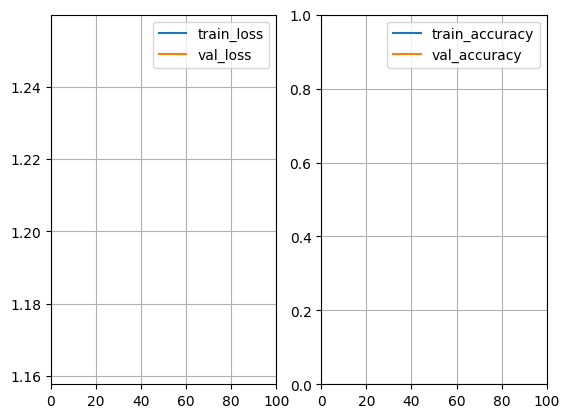

KeyboardInterrupt: 

In [25]:
train_loss_his, test_loss_his, train_his_acc, test_his_acc = train_model(net, x_train, y_train, x_val, y_val, 
                                                                         num_epochs, alpha, device, batch_size)

In [ ]:
!nvidia-smi
torch.save(net, "data/leave_model1.pt")